# Results

The script below runs the model, outputs the results, and generates the following figures:
- [Figures 1 & 2: Non-stationarity impacts](#fig1)
- [Crop coefficient figure](#fig3)
- [Dynamic Stress-Yield Relationships](#yields)
- [LGP impacts on yield](#lgp)

For imports/exports of simulations:
- Start [here](#import) where the 10,000 simulations are imported in to make figures for 180-day variety.
- Start [here](#import2) where the 10,000 simulations for the groups of varieties are made.

Last updated: 5 November 2020

In [1]:
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

# Uncomment for black background figure
# plt.rcParams.update({
#     "grid.color": "white",
#     'hatch.color': 'k',
#     "lines.color": "white",
#     "patch.edgecolor": "white",
#     'patch.facecolor': ([0, 1, 1]),
#     'grid.alpha': 0.4,
#     "text.color": "lightgray",
#     "axes.facecolor": "black",
#     "axes.edgecolor": "lightgray",
#     "axes.labelcolor": "white",
#     "xtick.color": "white",
#     "ytick.color": "white",
#     "grid.color": "lightgray",
#     "figure.facecolor": "black",
#     "figure.edgecolor": "black",
#     "savefig.facecolor": "black",
#     "savefig.edgecolor": "black"})

In [4]:
def run(n_sim = 80, burn_in = 60,  station = 'OL JOGI FARM', do_std = True, data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv',
    texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad'): # for 365 runs, lgp = 365, pd_sim = 1; otherwise lgp = 180, pd_sim=60
    """ Set up model conditions for model runs. 

    Usage: run(n_sim, burn_in, station, data_file, texture, lgp, pd_sim, interval)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        burn_in = 60 # Number of Days to Run for Initial Conditions Removal [integer]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [days]
        pd_sim 100 # Planting Date for Simulation [day of year]
        data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv' # Location of Rainfall Data [csv file]
        interval = 'dekad' # Time interval to calculate alpha and lambda parameters [string]

    """
    ## Step 1: Run model
    # Part 1. Set conditions for IC runs
    doy = pd_sim - burn_in
    while doy < 1:
        doy = 365 + doy
    
    print("Step 1: \n\t...Conducting burn in starting at doy {doy}, which is {burn_in} days before the simulated planting date of {pd_sim}.".format(
        doy=doy,
        burn_in=burn_in,
        pd_sim=pd_sim)
    )
    
    # Part 2. Initialize model with a climate, soil and crop
    print("Step 2: \n\t...Initializing {interval} lamba and alphas based on {station} using {data_file}.".format(
        interval=interval,
        station=station,
        data_file=data_file)
    )
   # Previous version: 
    s0_climate = Climate(
        data_file=data_file,
        station=station,
        interval=interval,
        do_std=False)
    
    print("\t...Initializing soil as {texture}".format(texture=texture))
    soil = Soil(texture=texture)
    
    print("\t...Initializing crop with {lgp} days to maturity".format(lgp=lgp))
    crop = Crop(soil=soil, lgp=lgp)
    
    print("\t...Setting nZr parameter to {nZr}".format(nZr=soil.set_nZr(crop)))
    soil.set_nZr(crop)
    
    model = CropModel(crop=crop, climate=s0_climate, soil=soil)
    
    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    n_burn_in_sims = max(10, int(n_sim*.10))
    print("Step 3: \n\t... Setting number of burn in simulations to {n_burn_in_sims}".format(
        n_burn_in_sims=n_burn_in_sims)
    )
    
    print("\t...Computing average soil moisture for doy {doy} using {n_sim} simulations".format(
        doy=doy,
        n_sim=n_burn_in_sims)
    )
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_burn_in_sims, doy=doy)
    print("\t\t[s0_mean]:{s0_mean}\t[s0_std]:{s0_std}".format(
        s0_mean=s0_mean,
        s0_std=s0_std)
    )
   # Version from historical cropping
#     models = [CropModel(
#                   crop=crop,
#                   climate=Climate( # this one is affected. 
#                       alpha_r= alpha_r, #s0_climate.alpha_r, # [100]*37, #, lambda_r= ## This definitely changed things!!!
#                       lambda_r= lambda_r, #s0_climate.lambda_r, # [0.5]*37, #
#                       lambda_std=s0_climate.lambda_std,
#                       do_std=True),
#                   soil=soil) for i in np.arange(n_sim)
#                ]
    
    # Previous version:
    models = [CropModel(
                  crop=crop,
                  climate=Climate(
                      alpha_r=s0_climate.alpha_r,
                      lambda_r=s0_climate.lambda_r,
                      lambda_std=s0_climate.lambda_std,
                      do_std=do_std), # Added variability to lambda.
                  soil=soil) for i in np.arange(n_sim)
               ]
    
    # Part 4. Run the actual simulations 
    print("Step 4: \n\t... Running {n_sim} simulations.".format(n_sim=n_sim))
    # We imported printProgressBar from functions.py earlier:
    printProgressBar(0, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
    output = []
    for i, model in enumerate(models):
        output.append(model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim))
        printProgressBar(i + 1, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
    #output = [model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim) for model in models]

    print("\t... Done.")

    # Part 5. Subset the growing period and get avg soil moisture
    print("Step 5: \n\t...Subsetting data to growing period.")
 
    start = burn_in 
    end = start + lgp
    avg_s = [df[start:end]['s'].mean() for df in output]
    
    # Part 6. Output the dynamic stress and yield values (just added this 08-17-2020)
    # old: x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress) for df in output] #for i in np.arange(n_sim)
    print("Step 6: \n\t...Calculating plant stress.")

    x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress, Y_MAX = evolved_calc_yield(dtm=lgp)) for df in output]
    
    #print(output[0][start:end].s)
    rf = [df[start:end]['R'].sum() for df in output]
    
    return x, rf, int(lgp), avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in

x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run(n_sim=10000)

Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on JACOBSON FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.6427087951372481	[s0_std]:0.05658043708052014
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [8]:
print(rf)
print("CV:",np.array(rf).std()/np.array(rf).mean())

[358.2436595712517, 844.5613429184043, 433.81046991046554, 451.0408404287984, 818.6390960092666, 539.3386713430043, 678.7109455790766, 601.3423851347162, 251.9703054383713, 467.5064672193182, 275.4820645173897, 527.5701816424223, 112.63364901581612, 120.71749526520233, 472.41588602188915, 656.6243820220833, 399.46050262363605, 589.16565988955, 306.307869430804, 213.249052036669, 768.671222092853, 408.25616673600894, 297.2216365219093, 616.2901373970537, 552.869488792026, 609.8963653241426, 337.9109401634886, 298.0234508586923, 77.53310838662495, 517.563911343794, 634.8926479602218, 898.2791208795013, 650.9614463749879, 766.8645371104458, 652.7799596241613, 813.7340537494847, 591.0590402690076, 578.6666106126909, 609.6106279257378, 156.2278757239213, 800.0185818230802, 469.8288958245516, 964.8937592930688, 719.9201152162055, 558.4035949680143, 777.8852984701407, 857.232158281967, 812.6758602964819, 455.8928817326061, 682.3922708289355, 524.8056235276117, 718.2054535884889, 765.950462210

In [5]:
# Check that the start and end is right.
# Should be 180 days time series with the first row, dos=1
output[1][start:end]

,kc,LAI,stress,R,s,E,ET,T,L,dsdt,dos,doy
60,0.300000,0.75,0.541290,0.000000,0.596069,0.747197,1.064327,0.317131,0.000000,-1.064327,1.0,60
61,0.300000,0.75,0.574692,5.689691,0.590479,0.907054,1.340791,0.433737,0.000000,4.348900,2.0,61
62,0.300000,0.75,0.444517,0.000000,0.613320,0.859658,1.259593,0.399935,0.000000,-1.259593,3.0,62
63,0.300000,0.75,0.480502,0.000000,0.606704,0.815910,1.184091,0.368181,0.000000,-1.184091,4.0,63
64,0.300000,0.75,0.515608,0.000000,0.600485,0.775486,1.113815,0.338330,0.000000,-1.113815,5.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.655556,3.00,0.003987,0.000000,0.764214,0.663091,5.160007,4.496916,0.000000,-5.160007,176.0,235
236,0.641667,3.00,0.029428,0.000000,0.737114,0.586343,4.562923,3.976579,0.000000,-4.562923,177.0,236
237,0.627778,3.00,0.071506,0.000000,0.713149,0.521148,4.037601,3.516453,0.000000,-4.037601,178.0,237
238,0.613889,3.00,0.124065,0.000000,0.691943,0.465635,3.574935,3.109300,0.000000,-3.574935,179.0,238


### Test out the code with this figure to see if it makes what we want: 

/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


s star 0.37128 sw 0.25228


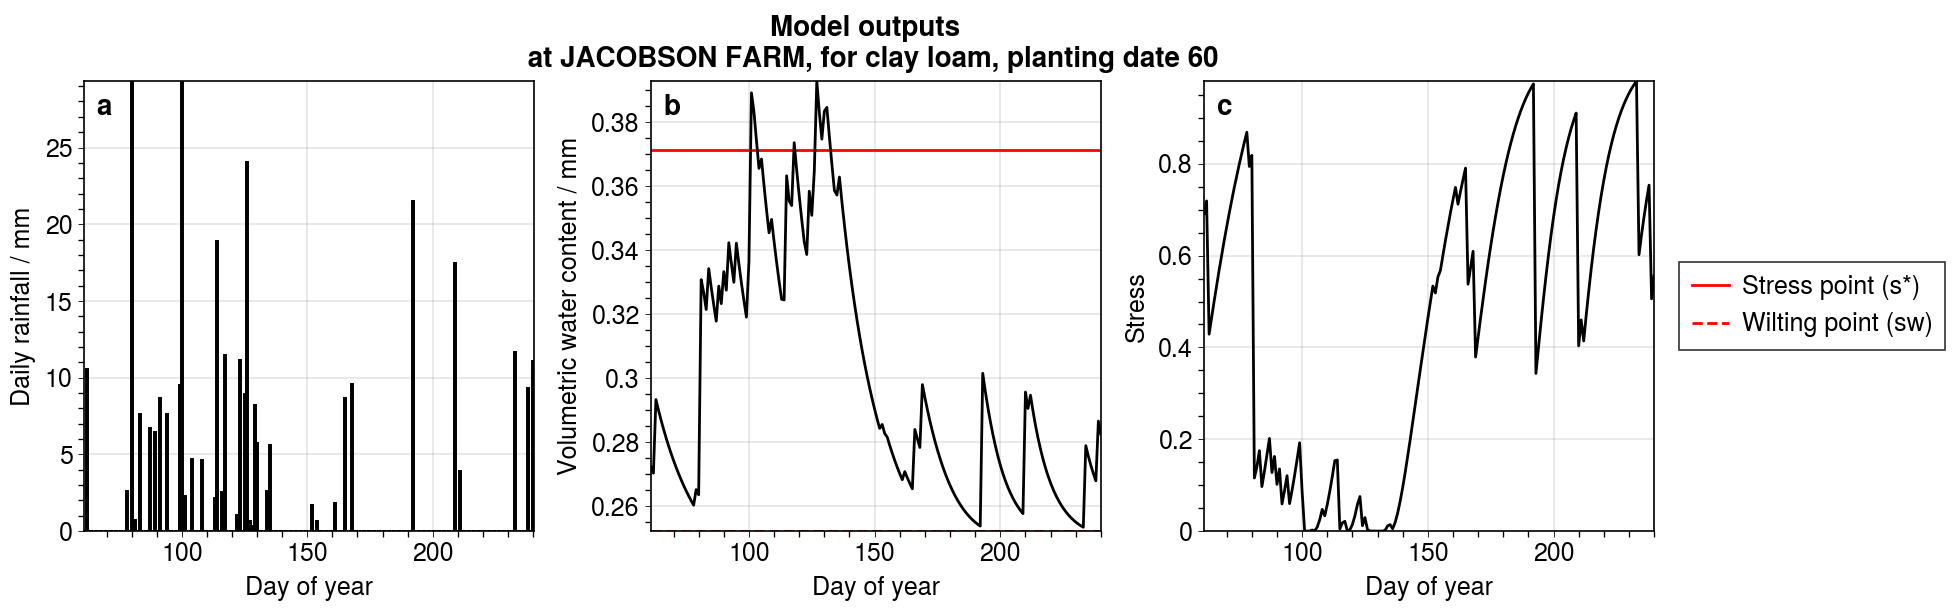

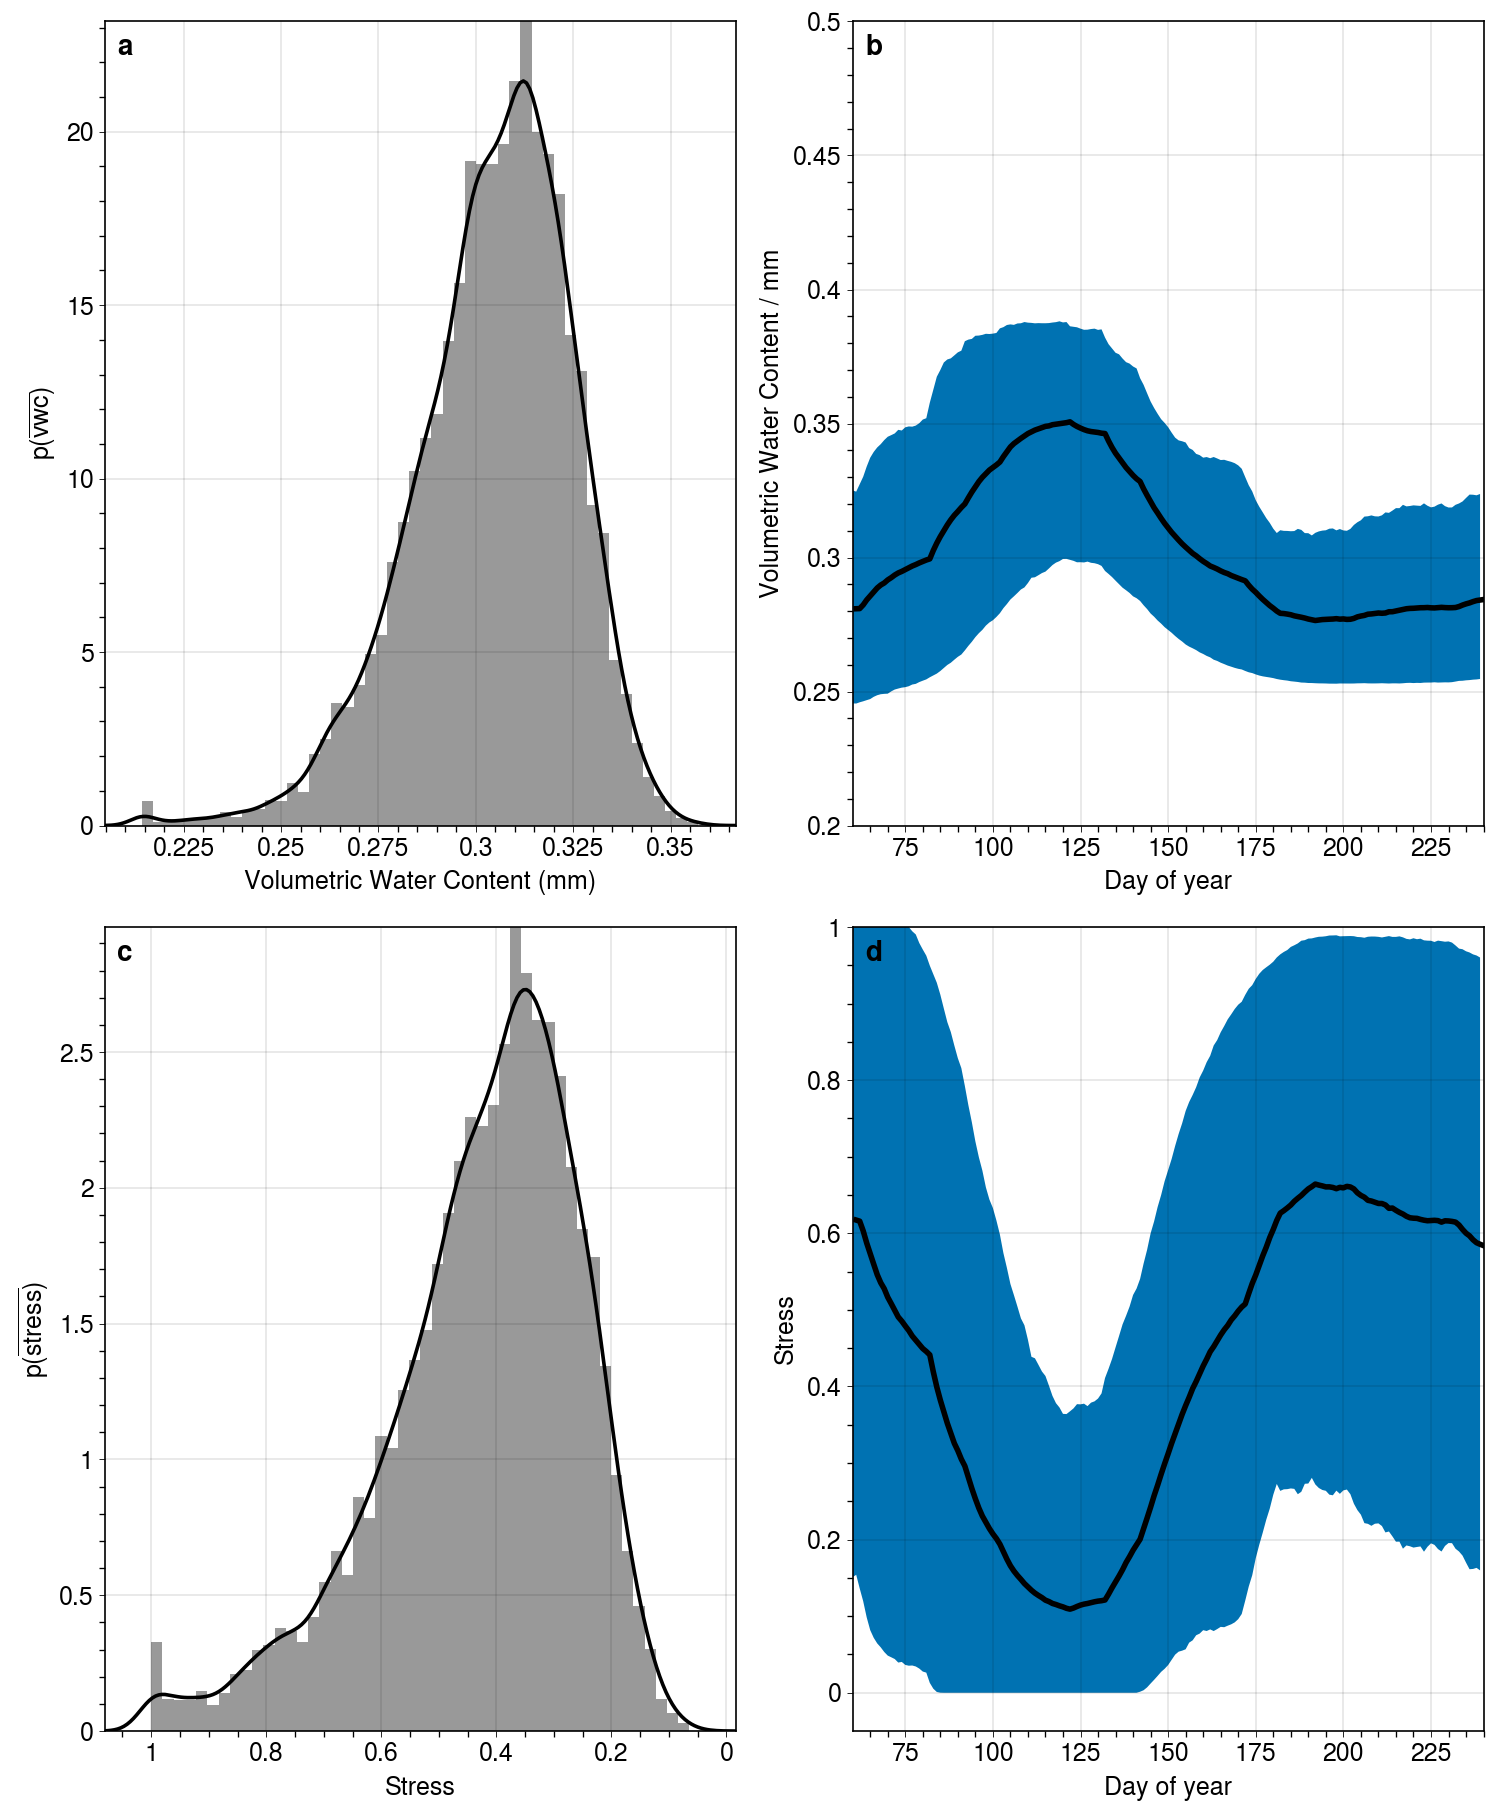

In [6]:
def figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)
        Takes all the outputs from the previous function and generates time series figure

    """
    # Step 2: Make figures
    # Part 6. Decide whether using white (publication) or black background (presentation): 
    # for white background
    col='k'
    
    # for black backgroumd
    #col='white'
    
    # If using the raw output need to have theses start and end vals:
    start = 60
    end = 240
    
    # If using reimported outputs, we can set start and end to 0 and 180:
    #start = 0 
    #end = 180
    #burn_in = 1
    
    f, axs = plot.subplots(nrows = 1, ncols = 3, share=0) # journal='agu1', tight=False
    axs.format(
        abc=True, abcloc='ul', suptitle='Model outputs \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
    )
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)

    # TOP FIGURE
    # Do some shenanigans to select a simulation that dips below wilting point
    s_min = []
    no_sims = np.arange(0,n_sim)
    
    for i in no_sims:
        #print(output[i][start:end]['s'].min())
        _s_min = output[i][start:end]['s'].min()
        s_min.append(_s_min)
    result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

    # which simulation has the smallest s value?
    lowest = result[['s_min']].idxmin().item() #result[126:] yup, looks good
    #print(lowest)
    lowest=1111
    # Figure 1a: Rainfall from one simulation
    rf = output[lowest][start:end]['R']
    stress = output[lowest][start:end]['stress']
    
    # Adjust index to account for the fact that python is zero-indexed
    rf.index = rf.index+1 # change index so that we can see day of season
    stress.index = stress.index+1
    
    axs[0,0].bar(rf, color=col, edgecolor=col) #darkblue, ,
    axs[0,0].format(ylabel='Daily rainfall / mm')
    #axs[0,0].format(xlabel='Day of season')
    axs[0,0].format(xlabel='Day of year')
    #axs[0,0].format(xlim=(60, 240))
    # Figure 1c: stress from one simulation
    axs[0,2].plot(stress, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,2].format(ylabel='Stress')
    #axs[0,2].format(xlim=(60, 240)) # xlim=(0, 0.4), 
    #axs[0,2].format(xlabel='Day of season')
    axs[0,2].format(xlabel='Day of year')
        
    # Figure 1b: Soil moisture from one simulation
    # convert saturation to volumetric water content:
    # relative saturation*porosity
    # we have the function theta already but I'm not sure that we call on that.
    vwc = output[lowest][start:end]['s']*Soil(texture).n
    
    _sstar = crop.s_star*Soil(texture).n # convert s_star and sw
    _sw = crop.sw*Soil(texture).n
    
    # LEGEND
    hs = []
    cycle = ['-','--']
    var = [_sstar, _sw]
    LABEL = ['Stress point (s*)','Wilting point (sw)']
    
    for item, cycle, LABEL in zip(var, cycle, LABEL):
        h = axs[0,1].axhline(y=item, lw=1, color='r', linestyle=cycle, label=LABEL)
        hs.append(h)
    
    f.legend(hs, loc='right', ncols=1, frame=True)
    
    # Adjust index to account for the fact that python is zero-indexed
    vwc.index = vwc.index+1 # need the time series to start at day 1 not day 61
    
    axs[0,1].plot(vwc, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,1].format(ylabel='Volumetric water content / mm')
    #axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(xlabel='Day of year')
    #axs[0,1].format(xlim=(60, 240))
    #plt.savefig('../output/6-results/fig1.png',format='png')
    
    # Figure 2
    f, axs = plot.subplots(nrows=2, ncols=2, share=0, journal='agu4')
    axs.format(abc=True, abcloc='ul') # suptitle='Figure 2'
    
    # Figure a: Soil moisture distribution - converted
    ax = axs[0,0]
    avg_s = np.array(avg_s)*Soil(texture).n
    sns.distplot(avg_s, ax=ax, color=col, **{'kde': True, 'hist': True}) # hist_kws={"color": 'gainsboro'}
    #ax.format(xlim=(0.2, 0.5), ylim=(0, 15))
    ax.format(ylabel=r'p($\overline{vwc}$)')
    ax.format(xlabel='Volumetric Water Content (mm)')
    
    # Figure c: Stress distribution
    ax = axs[1,0]
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    sns.distplot(avg_stress, ax=ax, color=col,**{'kde': True, 'hist': True}) # hist_kws={"color": 'black'
     
    #ax.format(xlim=(-0.1, 0.9), ylim=(0, 10))
    ax.format(ylabel=r'p($\overline{stress}$)')
    ax.format(xlabel='Stress')
    
    # Figure b: Soil moisture time series - need to convert this one
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1); avg_daily
    avg_daily = avg_daily*Soil(texture).n; avg_daily
    avg_daily_t = avg_daily.T; avg_daily_t
    daily_mean = avg_daily.mean(axis=1); daily_mean
    daily_mean.index = daily_mean.index+1 # Change index so that we can see day of season
    daily_mean
    #data = np.array(daily_mean)
    axs[0,1].plot(daily_mean, color=col, lw=2)

    #x = np.arange(1, len(daily_mean)+1, 1)
    # use this for raw output
    x = np.arange(60, 240, 1)

    # set custom x axis
    #axs[0,1].format(xlim=(60, 240)) #, ylim=(0, 10))
    
    quant = avg_daily_t.quantile([.1, .9])
    quant = quant.T
    axs[0,1].fill_between(x, quant[0.1], quant[0.9]) # ,facecolor='gainsboro'
    axs[0,1].format(ylim=(0.2, 0.5)) #xlim=(0.3, 0.8), 
    #axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(xlabel='Day of year')
    axs[0,1].format(ylabel='Volumetric Water Content / mm')
    
    # Figure f: stress time series
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean.index = daily_mean.index + 1 
    axs[1,1].plot(daily_mean, color=col, lw=2)

    #x = np.arange(1, len(daily_mean)+1, 1) 
    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[1,1].fill_between(x, quant[0.1], quant[0.9]) #,facecolor='dimgray'
    axs[1,1].format(ylim=(-0.05, 1))
    plt.ylabel('Stress')
    axs[1,1].format(ylabel='Stress')
    #axs[1,1].format(xlabel='Day of season')
    axs[1,1].format(xlabel='Day of year')
    ax.xaxis.label.set_color(col)
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)
    #axs.format(
    # set custom x axis
    #axs[1,1].format(xlim=(60, 240)) #
    #rowlabels=['Volumetric Water Content', 'Stress'],
    collabels=['PDF', 'Time Series']
    
    #plt.savefig('../output/6-results/fig2.png',format='png')
    print('s star',_sstar,'sw',_sw)

figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)

In [12]:
# To figure out a better time series to plot, use the following:

# return list of some of lowest time series
s_min = []
no_sims = np.arange(0,n_sim)

for i in no_sims:
    #print(output[i][start:end]['s'].min())
    _s_min = output[i][start:end]['s'].min()
    s_min.append(_s_min)
result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

# which simulation has the smallest s value?
lowest = result[['s_min']].idxmin().item()
print(lowest)

result.s_min.sort_values().head(10)

141


6858    0.43672
4462    0.43672
666     0.43672
8122    0.43672
3868    0.43672
7650    0.43672
5481    0.43672
5939    0.43672
1932    0.43672
4210    0.43672
Name: s_min, dtype: float64

## Parameters

Using the following parameters, generate 10,000 simulations.

TODO. Need to figure out how to extract each variable from this dictionary.

In [13]:
output_vars = {'n_sim': 10000, 'burn_in': 60, 'station': 'OL JOGI', 'texture': 'clay loam', 'lgp':180, 'pd_sim':60}
output_vars.keys()
for i in output_vars.keys():
    i = output_vars.items()

n_sim = 10000
no_sims = np.arange(1,n_sim)

burn_in = 60
station = 'OL JOGI'
texture = 'clay loam'
lgp=180
pd_sim=60

start = burn_in 
end = start + lgp

## Export 10,000 simulations

In [14]:
n_sim = 10000
no_sims = np.arange(0,n_sim)

# export simulations
for i in no_sims:
    output[i][start:end].to_csv('../output/results_11042020/%s.csv' % i) # remove /full_year/

## Reimport 10,000 simulations <a id='import'></a>

In [15]:
# this takes a while
files = glob.glob('../output/final/*.csv')
output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)

output[99]

,kc,LAI,stress,R,s,E,ET,T,L,dsdt,dos,doy
0,0.300000,0.75,1.000000,0.0,0.489119,0.183784,0.183784,0.000000,0.0,-0.183784,1.0,60
1,0.300000,0.75,1.000000,0.0,0.488154,0.179947,0.179947,0.000000,0.0,-0.179947,2.0,61
2,0.300000,0.75,1.000000,0.0,0.487209,0.176217,0.176217,0.000000,0.0,-0.176217,3.0,62
3,0.300000,0.75,1.000000,0.0,0.486283,0.172590,0.172590,0.000000,0.0,-0.172590,4.0,63
4,0.300000,0.75,1.000000,0.0,0.485377,0.169061,0.169061,0.000000,0.0,-0.169061,5.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.655556,3.00,0.716141,0.0,0.568437,0.187778,0.925773,0.737995,0.0,-0.925773,176.0,235
176,0.641667,3.00,0.749437,0.0,0.563575,0.178627,0.823267,0.644640,0.0,-0.823267,177.0,236
177,0.627778,3.00,0.779681,0.0,0.559251,0.170619,0.732240,0.561621,0.0,-0.732240,178.0,237
178,0.613889,3.00,0.807084,0.0,0.555405,0.163600,0.651382,0.487782,0.0,-0.651382,179.0,238


In [16]:
# Will also need this to make the figures
[df.set_index('dos') for df in output]
avg_s = [df[start:end]['s'].mean() for df in output]
soil = Soil(texture=texture)
crop = Crop(soil=soil, lgp=lgp)

In [17]:
output[2]

,kc,LAI,stress,R,s,E,ET,T,L,dsdt,dos,doy
0,0.300000,0.75,1.000000,0.000000,0.478859,0.144421,0.144421,0.000000,0.000000,-0.144421,1.0,60
1,0.300000,0.75,1.000000,0.000000,0.478101,0.141639,0.141639,0.000000,0.000000,-0.141639,2.0,61
2,0.300000,0.75,1.000000,0.000000,0.477357,0.138927,0.138927,0.000000,0.000000,-0.138927,3.0,62
3,0.300000,0.75,1.000000,0.000000,0.476627,0.136285,0.136285,0.000000,0.000000,-0.136285,4.0,63
4,0.300000,0.75,1.000000,0.000000,0.475911,0.133709,0.133709,0.000000,0.000000,-0.133709,5.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.655556,3.00,0.074619,0.000000,0.711709,0.517314,4.006122,3.488809,0.000000,-4.006122,176.0,235
176,0.641667,3.00,0.127683,0.000000,0.690668,0.462366,3.547196,3.084830,0.000000,-3.547196,177.0,236
177,0.627778,3.00,0.186493,6.102108,0.672038,0.497172,3.839640,3.342468,0.000000,2.262468,178.0,237
178,0.613889,3.00,0.147700,0.000000,0.683921,0.445184,3.400462,2.955278,0.000000,-3.400462,179.0,238


## Using the imported time series, make the figures:

### Figures 1 and 2: Time series and PDFs <a id='fig1'></a>

Note for the rainfall time series below, when we do more than 1000+ simulations, we pull out abnormal years where there can be 100 mm in a day. So when we run the final 10,000 time series, just take care to pick a good looking plot for the paper.

IndexError: list index out of range

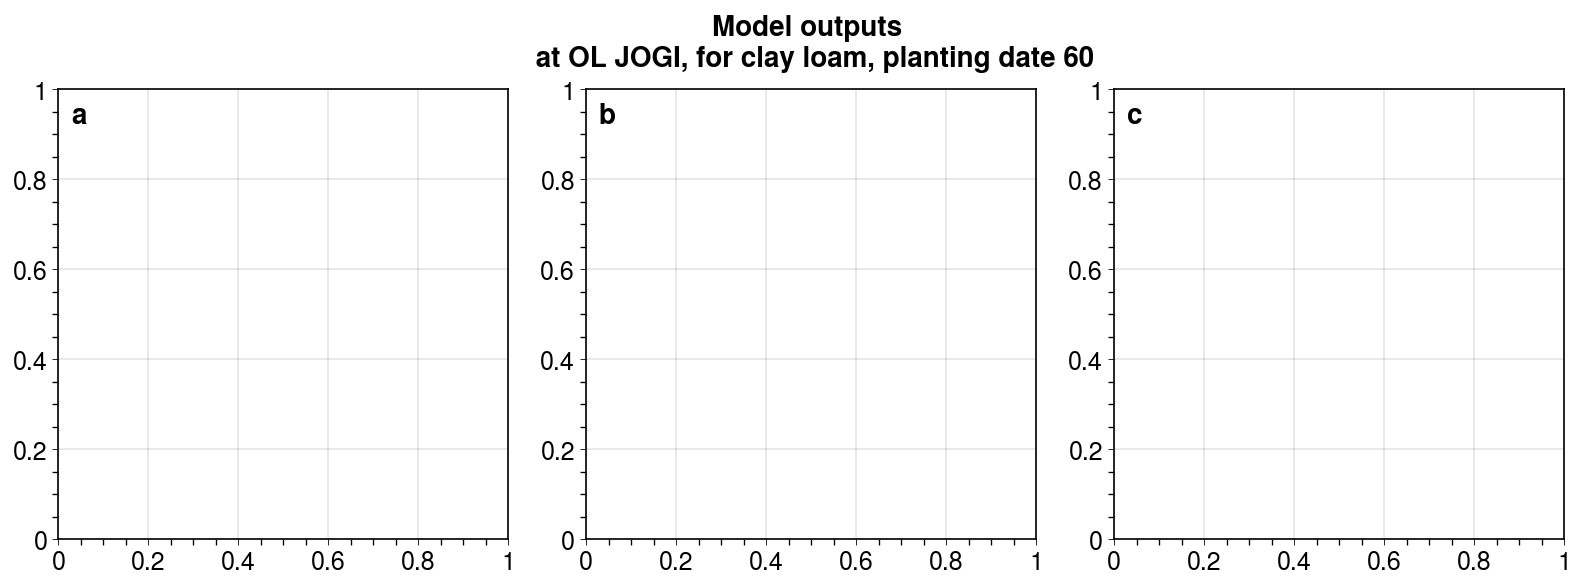

In [18]:
def figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)
        Takes all the outputs from the previous function and generates time series figure

    """
    # Step 2: Make figures
    # Part 6. Decide whether using white (publication) or black background (presentation): 
    # for white background
    col='k'
    
    # for black backgroumd
    #col='white'
    
    # Since we're using the reimported outputs, we can set start and end to 0 and 180
    start = 0 
    end = 180
    #burn_in = 1
    # If we were using the raw output we'd need to have the previous start and end values
    
    f, axs = plot.subplots(nrows = 1, ncols = 3, share=0) # journal='agu1', tight=False
    axs.format(
        abc=True, abcloc='ul', suptitle='Model outputs \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
    )
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)

    # TOP FIGURE
    # Do some shenanigans to select a simulation that dips below wilting point
    s_min = []
    no_sims = np.arange(0,n_sim)
    
    for i in no_sims:
        #print(output[i][start:end]['s'].min())
        _s_min = output[i][start:end]['s'].min()
        s_min.append(_s_min)
    result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

    # which simulation has the smallest s value?
    lowest = result[['s_min']].idxmin().item() #result[126:] yup, looks good
    #print(lowest)
    lowest=745
    # Figure 1a: Rainfall from one simulation
    rf = output[lowest][start:end]['R']
    stress = output[lowest][start:end]['stress']
    
    # Adjust index to account for the fact that python is zero-indexed
    rf.index = rf.index+1 # change index so that we can see day of season
    stress.index = stress.index+1
    
    axs[0,0].bar(rf, color=col, edgecolor=col) #darkblue, ,
    axs[0,0].format(ylabel='Daily rainfall / mm')
    #axs[0,0].format(xlabel='Day of season')
    axs[0,0].format(xlabel='Day of year')
    #axs[0,0].format(xlim=(60, 240))
    # Figure 1c: stress from one simulation
    axs[0,2].plot(stress, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,2].format(ylabel='Stress')
    #axs[0,2].format(xlim=(60, 240)) # xlim=(0, 0.4), 
    #axs[0,2].format(xlabel='Day of season')
    axs[0,2].format(xlabel='Day of year')
        
    # Figure 1b: Soil moisture from one simulation
    # convert saturation to volumetric water content:
    # relative saturation*porosity
    # we have the function theta already but I'm not sure that we call on that.
    vwc = output[lowest][start:end]['s']*Soil(texture).n
    
    _sstar = crop.s_star*Soil(texture).n # convert s_star and sw
    _sw = crop.sw*Soil(texture).n
    
    # LEGEND
    hs = []
    cycle = ['-','--']
    var = [_sstar, _sw]
    LABEL = ['Stress point (s*)','Wilting point (sw)']
    
    for item, cycle, LABEL in zip(var, cycle, LABEL):
        h = axs[0,1].axhline(y=item, lw=1, color='r', linestyle=cycle, label=LABEL)
        hs.append(h)
    
    f.legend(hs, loc='right', ncols=1, frame=True)
    
    # Adjust index to account for the fact that python is zero-indexed
    vwc.index = vwc.index+1 # need the time series to start at day 1 not day 61
    
    axs[0,1].plot(vwc, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,1].format(ylabel='Volumetric water content / mm')
    #axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(xlabel='Day of year')
    #axs[0,1].format(xlim=(60, 240))
    #plt.savefig('../output/6-results/fig1.png',format='png')
    
    # Figure 2
    f, axs = plot.subplots(nrows=2, ncols=2, share=0, journal='agu4')
    axs.format(abc=True, abcloc='ul') # suptitle='Figure 2'
    
    # Figure a: Soil moisture distribution - converted
    ax = axs[0,0]
    avg_s = np.array(avg_s)*Soil(texture).n
    sns.distplot(avg_s, ax=ax, color=col, **{'kde': True, 'hist': True}) # hist_kws={"color": 'gainsboro'}
    #ax.format(xlim=(0.2, 0.5), ylim=(0, 15))
    ax.format(ylabel=r'p($\overline{vwc}$)')
    ax.format(xlabel='Volumetric Water Content (mm)')
    
    # Figure c: Stress distribution
    ax = axs[1,0]
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    sns.distplot(avg_stress, ax=ax, color=col,**{'kde': True, 'hist': True}) # hist_kws={"color": 'black'
     
    #ax.format(xlim=(-0.1, 0.9), ylim=(0, 10))
    ax.format(ylabel=r'p($\overline{stress}$)')
    ax.format(xlabel='Stress')
    
    # Figure b: Soil moisture time series - need to convert this one
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1); avg_daily
    avg_daily = avg_daily*Soil(texture).n; avg_daily
    avg_daily_t = avg_daily.T; avg_daily_t
    daily_mean = avg_daily.mean(axis=1); daily_mean
    daily_mean.index = daily_mean.index+1 # Change index so that we can see day of season
    daily_mean
    #data = np.array(daily_mean)
    axs[0,1].plot(daily_mean, color=col, lw=2)

    # Use this for imported vals
    x = np.arange(1, len(daily_mean)+1, 1)
    # use this for raw output
    #x = np.arange(60, 240, 1)

    # set custom x axis
    #axs[0,1].format(xlim=(60, 240)) #, ylim=(0, 10))
    
    quant = avg_daily_t.quantile([.1, .9])
    quant = quant.T
    axs[0,1].fill_between(x, quant[0.1], quant[0.9]) # ,facecolor='gainsboro'
    axs[0,1].format(ylim=(0.2, 0.5)) #xlim=(0.3, 0.8), 
    #axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(xlabel='Day of year')
    axs[0,1].format(ylabel='Volumetric Water Content / mm')
    
    # Figure f: stress time series
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean.index = daily_mean.index + 1 
    axs[1,1].plot(daily_mean, color=col, lw=2)

    #x = np.arange(1, len(daily_mean)+1, 1) 
    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[1,1].fill_between(x, quant[0.1], quant[0.9]) #,facecolor='dimgray'
    axs[1,1].format(ylim=(-0.05, 1))
    plt.ylabel('Stress')
    axs[1,1].format(ylabel='Stress')
    #axs[1,1].format(xlabel='Day of season')
    axs[1,1].format(xlabel='Day of year')
    ax.xaxis.label.set_color(col)
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)
    #axs.format(
    # set custom x axis
    #axs[1,1].format(xlim=(60, 240)) #
    #rowlabels=['Volumetric Water Content', 'Stress'],
    collabels=['PDF', 'Time Series']
    
    #plt.savefig('../output/6-results/fig2.png',format='png')
    print('s star',_sstar,'sw',_sw)

figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)

### Figure 3: Three figures including crop coefficient <a id='fig3'></a>

In [19]:
s0_climate = Climate(station='OL JOGI FARM', data_file='../data/CETRAD/CETRAD_rainfall.csv', interval='dekad')

In [20]:
# We want the unique values of alpha_r and lambda_r, so grab every 10th element of the list 
a = s0_climate.alpha_r[0::10]
l = s0_climate.lambda_r[0::10]

In [21]:
# make a dataframe
dekads = pd.DataFrame({'alpha':a, 'lambda':l, 'dekad':np.arange(1,38,1),'day':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                               '170','180','190','200','210','220',
                                                                               '230','240','250','260','270','280','290',
                                                                               '300','310','320','330','340','350','360','365'
                                                                              ]})

[Text(0, 0.5, 'Relative soil \n moisture content, $\\mathit{s}$')]

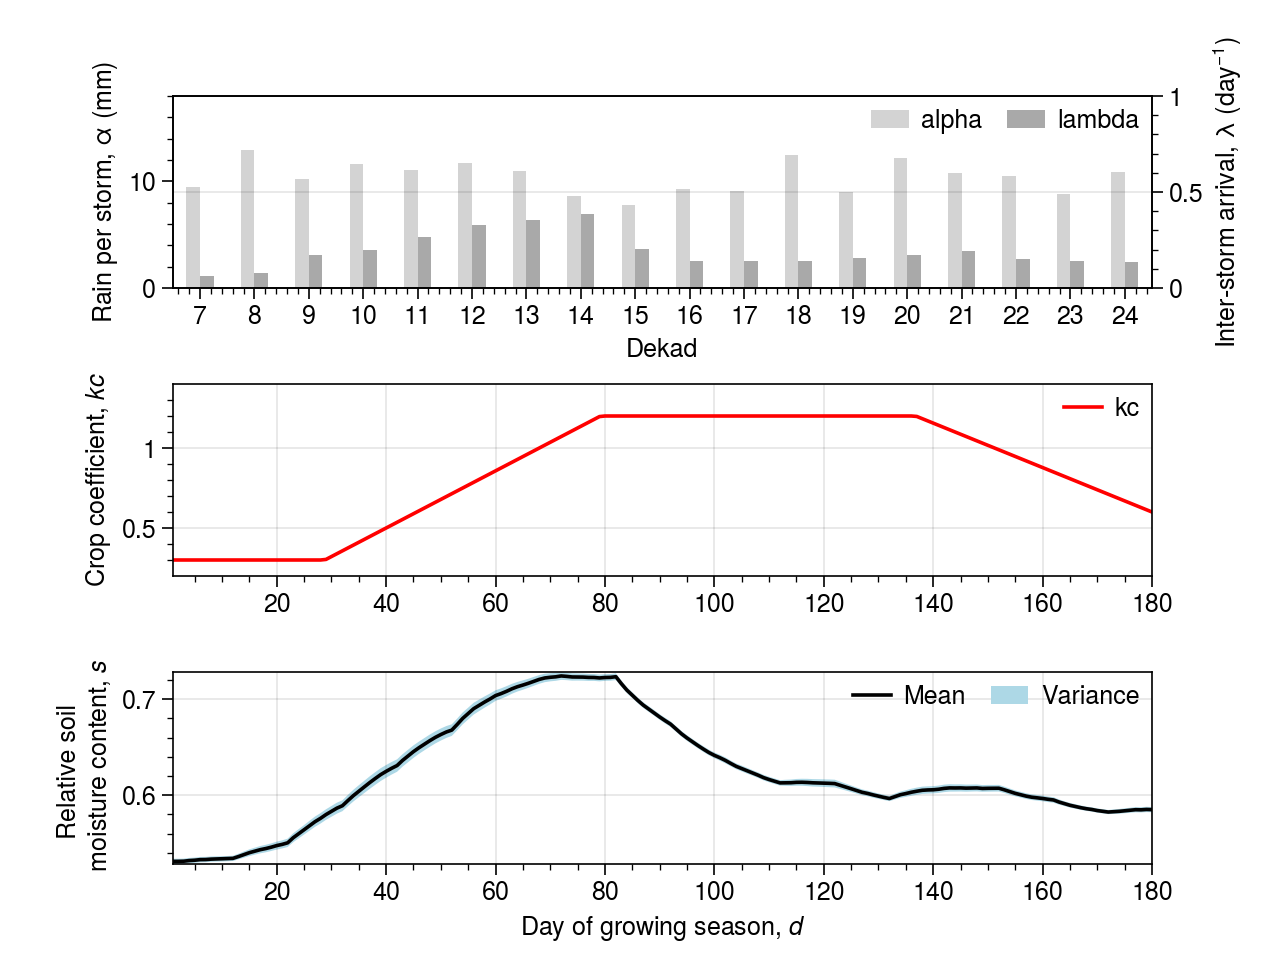

In [22]:
# figure set up
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1, sharex=False)
#fig, axs = plot.subplots(nrows=3, ncols=1, sharex=False)
left   =  0.135  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .3     # the amount of width reserved for blank space between subplots
hspace =  0.5    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)
#axs.format(abc=True, abcloc='ul', suptitle='Non-stationarity in Model Parameters')

# The amount of space above titles
#y_title_margin = 1.2

# Plot a) Rainfall climatology
# I'm not sure that I need anything from above

# now create a longer timeseries using month three to eight: March 1st and 1980 days later.

#subset dataframe
dekads = dekads[6:24].set_index('dekad').drop(['day'], axis=1)


dekads.plot(kind="bar", ax=ax1, ylim=(0,18),rot=360, color=['lightgray','darkgray']) # hatch=('-','//')
ax1_ = ax1.twinx()
for r in ax1.patches[len(dekads):]:
    r.set_transform(ax1_.transData)

ax1.set_ylabel(r'Rain per storm, $\alpha$ (mm)')
ax1_.set_ylabel('Inter-storm arrival, $\lambda$ (day$^{-1}$)')
#ax1.set_xlabel([], color='white')
ax1.set_xlabel('Dekad')
ax1_.set_xlabel([''])

ax1.legend(frameon=False, ncol=2)
ax1.grid(which='major',axis='both')


# Plot b) Crop Coefficient
o = output[0]
o.index = o.index+1 # make doy cooperate better
ax2.plot(o['kc'], 'r-') 
ax2.set(ylabel='Crop coefficient, $\mathit{kc}$')
ax2.set_ylim(0.2, 1.4)
ax2.legend(['kc'],frameon=False)

# Plot c) Saturation
# get average saturation
#[df.set_index('dos') for df in output]
avg_df_180 = pd.concat([df['s'] for df in output], axis=1)                          
avg_df_180["mean"] = avg_df_180.mean(axis=1)  
avg_df_180["var"] = avg_df_180.var(axis=1)  
df_180 = avg_df_180
df_180 = df_180[0:180] ##############!!!!!!!!!!!!!!!! something is goofy here, come back and take a look
df_180.index = df_180.index+1 # make doy cooperate better

ax3.plot(df_180['mean'], 'k-')
x = np.arange(1, len(df_180)+1, 1)
ax3.fill_between(x, df_180['var']+df_180['mean'], df_180['mean']-df_180['var'],facecolor='lightblue') #, facecolor='lightsalmon'
ax3.set(xlabel='Day of growing season, $\mathit{d}$')
ax3.legend(['Mean', 'Variance'], ncol=2, frameon=False)
ax3.set(ylabel='Relative soil \n moisture content, $\mathit{s}$')
#plt.savefig('../output/6-results/threefigs_dekadal.png',format='png')

In [23]:
output

# I do not know what's going on 

[           kc   LAI    stress    R         s         E        ET         T  \
 1    0.300000  0.75  0.259858  0.0  0.652559  1.134257  1.722541  0.588284   
 2    0.300000  0.75  0.298062  0.0  0.643512  1.068718  1.613577  0.544859   
 3    0.300000  0.75  0.336225  0.0  0.635038  1.008516  1.512696  0.504181   
 4    0.300000  0.75  0.374090  0.0  0.627093  0.953144  1.419189  0.466045   
 5    0.300000  0.75  0.411450  0.0  0.619639  0.902151  1.332419  0.430268   
 ..        ...   ...       ...  ...       ...       ...       ...       ...   
 176  0.655556  3.00  0.934550  0.0  0.538320  0.133634  0.293372  0.159739   
 177  0.641667  3.00  0.946504  0.0  0.536779  0.131032  0.261187  0.130155   
 178  0.627778  3.00  0.957211  0.0  0.535407  0.128730  0.232547  0.103817   
 179  0.613889  3.00  0.966794  0.0  0.534186  0.126692  0.207058  0.080367   
 180  0.600000  3.00  0.975367  0.0  0.533098  0.124886  0.184373  0.059487   
 
        L      dsdt    dos  doy  
 1    0.0 -1.722

In [24]:
avg_df_180

# Check if this fixes the problem

,s,s,s,s,s,s,s,s,s,s,...,s,s,s,s,s,s,s,s,mean,var
0,NaN,0.483622,0.478859,0.512987,0.637697,0.469450,0.532779,0.491869,0.597340,0.625065,...,0.490575,0.477017,0.487926,0.535085,0.489020,0.531466,0.573151,0.482593,0.530993,0.002745
1,0.652559,0.482770,0.478101,0.511481,0.629586,0.468866,0.530698,0.490846,0.591675,0.617736,...,0.489579,0.476294,0.486986,0.532883,0.488057,0.529452,0.568879,0.481761,0.531007,0.002747
2,0.643512,0.481935,0.477357,0.510011,0.621979,0.468292,0.528724,0.489844,0.586342,0.610854,...,0.488604,0.475584,0.486065,0.530796,0.487114,0.527529,0.599659,0.480945,0.531165,0.002712
3,0.635038,0.481116,0.476627,0.508577,0.614839,0.467729,0.526819,0.488863,0.581318,0.636909,...,0.487650,0.502805,0.548233,0.528817,0.486191,0.525656,0.684368,0.480146,0.531821,0.002758
4,0.627093,0.480313,0.475911,0.507176,0.608131,0.467175,0.524965,0.487904,0.576582,0.628847,...,0.486715,0.501540,0.545334,0.551166,0.485286,0.523832,0.681265,0.479363,0.532176,0.002764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.538320,0.542624,0.690668,0.522055,0.559645,0.534267,0.542112,0.522878,0.544846,0.551374,...,0.576409,0.520648,0.563925,0.532868,0.617151,0.579631,0.546656,0.533674,0.584851,0.002733
177,0.536779,0.540610,0.672038,0.521493,0.555756,0.533171,0.540154,0.522308,0.542588,0.548397,...,0.580252,0.520098,0.559563,0.531925,0.606853,0.573526,0.544199,0.619038,0.584722,0.002728
178,0.535407,0.538818,0.683921,0.672863,0.552296,0.532195,0.538412,0.521744,0.540578,0.545749,...,0.574078,0.519551,0.555683,0.531085,0.597711,0.568100,0.556091,0.626568,0.585119,0.002757
179,0.534186,0.537223,0.666061,0.656264,0.549218,0.531325,0.536861,0.521185,0.658605,0.583000,...,0.568590,0.519010,0.557347,0.530337,0.589591,0.563275,0.552595,0.615211,0.584908,0.002734


### Fig. 4 Dynamic Stress-Yield Relationship <a id='yields'></a>

In [7]:
# line up the data
data = [crop.calc_dstress(s=df.s, stress=df.stress) for df in output] #for i in np.arange(n_sim)
rf = [df['R'].sum() for df in output]

In [8]:
# Turn dynamic water stress data into a tuple
df = pd.DataFrame.from_records(data, columns =['AvgStress2','DynamicStress','Yield'])
df['RF'] = rf
print(max(df.Yield)/1000)

2.9292465698544996


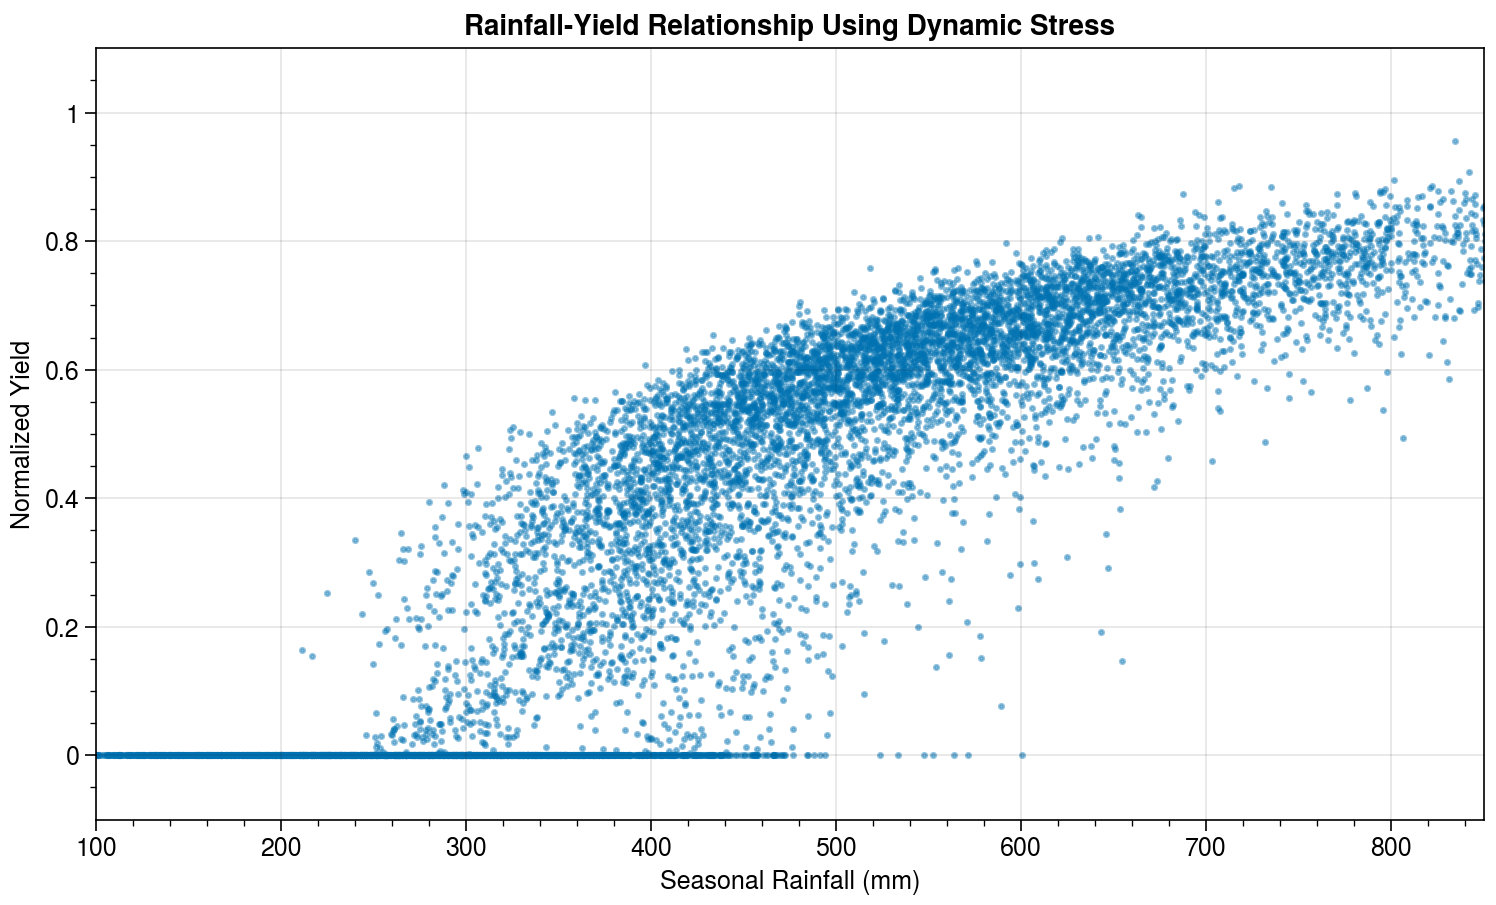

In [9]:
# Dynamic Stress Yield Rlxn

def fig3(df=None):
    # We'll be using these variables a lot
    x = df.RF
    y = df.Yield

    # Scatter plot of raw data
    max(df.Yield)

    df['Yield_norm'] = df.Yield/max(df.Yield)

    f, axs = plot.subplots(journal='agu2') #, tight=False
    axs.format(
        abc=False, abcloc='ul', suptitle='Rainfall-Yield Relationship Using Dynamic Stress')
    
    
    plt.scatter(df.RF, df.Yield_norm, alpha=0.4, size=2.5) # , color='black'
    plt.ylim(-.10,1.10)
    plt.xlim(100,850)
    #plt.title('Rainfall-Yield Relationship Using Dynamic Stress')
    plt.ylabel('Normalized Yield') # Yield normalized by max. yield
    plt.xlabel('Seasonal Rainfall (mm)')
    #plt.savefig('../output/6-results/dynstress2.png',format='png')
    # New fit
    #residuals = plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)')
    
    #power_law_fit(x,y,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')
    # confidence intervals around line?
    
fig3(df=df)

## Step 3. Export then import simulations for varieties <a id='import2'></a>

In [ ]:
# Started off with this but doesn't have evolved calc yields. Need to combine what's below with what's above.

# This timed out. 
def run2():

    # Now I have to re-run the simulations using the max yields from this relationship
    varieties = np.arange(75,180,5)
    len(varieties)

    result = []

    for i in varieties:
        # note: bumping up to 200 sims per cultivar type takes several minutes to run
        # whereas 100 sims where varieties = np.arange(70,200,5) takes less than a minute.
        data, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run(n_sim = 500, station = 'OL JOGI FARM', texture = 'clay loam', lgp=i, pd_sim=60)
        df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
        df['RF'] = rf
        df['Cultivar'] = i
        result.append(df)
        
    return result

result = run2()
result = pd.concat(result)

# Add categorical values for early, medium and late maturing
# There is probably a way more efficient way to do this
def category(x):
    if x < 110:
        return "Early (< 105 d)"
    if 110 <= x <= 140:
        return "Medium (110 - 140 d)"
    else:
        return "Late (145 + d)"

for row in result.Cultivar:
    result['Category'] = result.Cultivar.apply(lambda x: category(x))

result.Category.value_counts()

In [ ]:
result.to_csv('../output/result08302020.csv',sep=',')

### LGP impacts on yield <a id='lgp'></a>

In [ ]:
def plot_lin_regression(x_var = None, y_var = None, x_str = None, y_str = None, data = None, 
                            ann_x = 101, ann_y = 4500, 
                            x_lab = 'X label here', y_lab = 'Y label here', title = 'Title here', positive = False):
        """ Computes linear regression between independent and dependent variable. 
        Usage: plot_lin_regression(x_var, y_var, x_lab, y_lab, title)
            ann_x = where on x-axis annotation should be placed
            ann_y = where on y-axis annotation should be placed
            Returns: R_squared, m, b
        """
        # Define variables
        X, y = x_var, y_var

        # Linear regression
        denominator = X.dot(X) - X.mean() * X.sum()
        m = ( X.dot(y) - y.mean() * X.sum() ) / denominator
        b = (y.mean() * X.dot(X) - X.mean() * X.dot(y) ) / denominator

        y_pred = m*X + b

        # uncomment for white figure
        col = 'black'
        #col = 'white'
        
        
        plt.figure(figsize=(5,4))

        g = sns.lmplot(x_str, y_str, data, ci=95, height=4, scatter_kws={'color':col,'alpha':0.6}) # ,, line_kws={'color': 'black'}

        # Calculate residuals
        res = y - y_pred
        tot = y - y.mean()

        R_squared = 1 - res.dot(res) / tot.dot(tot)
        print(R_squared)
        print('m',m)
        print('b',b)

        if positive == True:
            textstr = '\n'.join((
                r'$ y = %.2f$x' % (m, )+'+$  %0.1f$' % (b, ),
                r'$r^2 = %.2f$' % (R_squared, ))) 
        else:
            textstr = '\n'.join((
            r'$ y = %.2f$x' % (m, )+'$  %.1f$' % (b, ),
            r'$r^2 = %.2f$' % (R_squared, )))

        props = dict(boxstyle='square', facecolor='white', alpha=0.5, lw = 1.5) # , ec="b"

        # place a text box in upper left in axes coords
        plt.text(ann_x, ann_y, textstr, fontsize=10, #transform=ax.transAxes, 
                verticalalignment='top', bbox=props)

        plt.xlabel(x_lab)
        plt.ylabel(y_lab)
        plt.ylim(1,5.2)
        plt.title(title, fontweight="bold")

        return R_squared, m, b
    
def fig4():
    # verified using Kenya Seed Co. - https://web.archive.org/web/20190819125927/http://kenyaseed.com/gallery/maize/
    verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')
    verified_hybrid_data


    # convert to metric tons
    verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
    verified_hybrid_data
    

    p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                                  'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                                  85, 5, 'Days to Maturity (days)', 'Potential Yield (tons/ha)', 
                                  'Kenya Seed Co. Potential Yields by Maize Variety')
    
fig4()
plt.savefig('../output/6-results/ksc.pdf',format='pdf')
plt.savefig('../output/6-results/ksc.png',format='png')

### Summary statistics

In [ ]:
# Note to self, this is for getting yields in G3S talk.
x = [crop.calc_dstress(s=df.s, stress=df.stress) for df in output]
print(x[847])
print(output[847][start:end]['R'].sum())

In [ ]:
# want to have table average yield, average rainfall

df = pd.DataFrame(x)
print(df[2].describe())
print(df[2].median())

s_min = []

# rainfall statistics
for i in no_sims:
    #print(output[i][start:end]['s'].min())
    _s_min = output[i][start:end]['R'].sum()
    s_min.append(_s_min)
result = pd.DataFrame({'s_min':s_min})
result.s_min.median()

In [13]:
result = df

In [14]:
## Do table and plot
table = pd.DataFrame({
            'Average Rainfall (mm)':[result.RF.mean()],
            'SD Rainfall':[np.std(result.RF)],
            'CV Rainfall':[result.RF.std()/result.RF.mean()],
            'Average Yield (t/ha)': [np.nanmean(result.Yield)],
            'Probability of Crop Failure (%)':[len(result.loc[result['Yield'] == 0].count(axis=1))/len(result)*100]})
table

,Average Rainfall (mm),SD Rainfall,CV Rainfall,Average Yield (t/ha),Probability of Crop Failure (%)
0,467.44435,183.089527,0.391702,1193.256715,25.94


In [ ]:
# need to output the 10,000 simulations into one dataframe (?) for export
# But then also need to truncate just to start and end for each sim.
# Should be able to do that using a for loop.
#pd.concat(output)
#plt.rcParams.keys()

Notes: How to bound the kde fit on static water stress to zero?
* [DataCamp](https://www.datacamp.com/community/tutorials/probability-distributions-python) article talks about distributions and exponential one still has curve that overflows to zero.
* [Stackoverflow](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python) says only option is to cut the axis limits to zero. Also [here](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python). Explanation for why you can get negative values from a positive density kernel density estimation, [stackexchange](https://stats.stackexchange.com/questions/109549/negative-density-for-non-negative-variables).